In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Get odds data with event outcomes for ATP and WTA tennis match outcomes. Data pulled from here: https://www.kaggle.com/datasets/hakeem/atp-and-wta-tennis-data

Idea of the betting strategy: the bookies have very good models and set odds accurately so no point in trying to estimate these odds yourself. We can find the consensus implied probability for any particular tennis match by simply taking the average across the different bookies (implied probability for a particular game is just the inverse of the offered coefficient). Then we find matches with an offered coefficient which substantially deviates from the consensus. We are seeking events where the consensus implied probability is larger than the specific implied probability. This means that the implied probability is smaller than it actually is so we have an edge. We then use Kelly's criterion to calculate the fraction of the total capital we should bet on the event. Strictly speaking, the Kelly criterion works when the probabilities of win/loss do not change over time and when these probabilities are accurate. In practice we can not satisfy any of these conditions. But lets see how well we can do, using some manual tweaks to make the strategy generate positive returns.

In [2]:
path_1 = r'df_atp.csv'
path_2 = r'df_wta.csv'
df_1 = pd.read_csv(path_1)
df_2 = pd.read_csv(path_2)
df = pd.concat([df_1, df_2], axis=0)

C:\Users\sjurg\AppData\Local\Temp\ipykernel_38400\2524512236.py:3: DtypeWarning: Columns (15,21,22,28,31,47,48,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv(path_1)
C:\Users\sjurg\AppData\Local\Temp\ipykernel_38400\2524512236.py:4: DtypeWarning: Columns (3,12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv(path_2)


In [3]:
odd_stats = df[~(df['MaxW'].isna() & df['MaxL'].isna() & df['AvgW'].isna() & df['AvgL'].isna())][['MaxW', 'MaxL', 'AvgW', 'AvgL']]
np_odd_stats = np.array(odd_stats)

(0.0, 491.0)

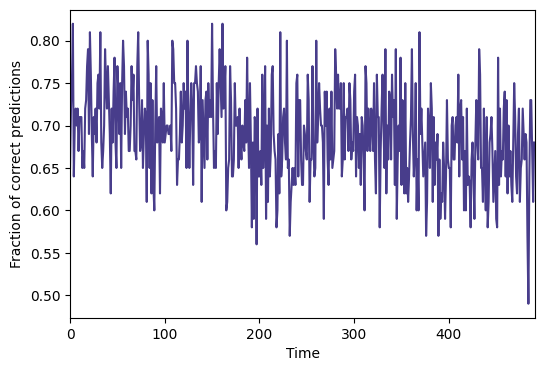

In [42]:
# Look at how consistent the bookies are at predicting the match winner (assuming the events in the data set are time ordered):
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(range(491), (np_odd_stats[:, 2] < np_odd_stats[:, 3])[:49100].reshape(491, 100).sum(axis=1) / 100, color='darkslateblue')
ax.set_xlabel('Time')
ax.set_ylabel('Fraction of correct predictions')
ax.set_xlim([0, 491])

Lets run a tweaked up Kelly strategy on all games and see how it performs...
The tweaks: bet half the Kelly fraction, use thresholds on the coefficients and the egde to select bets.
Below is a graph of the different paths the capital would take using this betting strategy. The paths are formed by randomly shuffling the time order of the events. There are a few paths which dramatically increase the capital. At the end we have a roughly factor 40 gain.

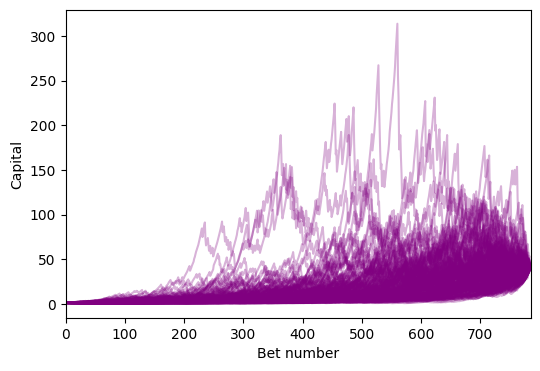

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('Bet number')
ax.set_ylabel('Capital')

final_caps = []
mins = []
max_caps = []
for j in range(200):
    np.random.shuffle(np_odd_stats)

    capital = 1
    fs, caps, ps, bet_sizes, maxs, avgs = [], [], [], [], [], []
    for i in np_odd_stats:
        coeff_max = min(i[:2]) # Largest offered coefficient by a bookmaker. Always choose the smaller of the pair -> always bet on favourite.
        coeff_avg = min(i[2:]) # Consensus coefficient.
        p = 1 / coeff_avg
        q = 1 - p
        f = p - q / (coeff_max - 1)
        fs.append(f)
        ps.append(p)
        bet_sizes.append(f * capital)
        maxs.append(coeff_max)
        avgs.append(coeff_avg)
        if (1 / coeff_avg - 1 / coeff_max > 0.05) and (coeff_max < 1.5):
            if i[0] < i[1]:
                capital += 0.5 * f * capital * (coeff_max - 1)
                caps.append(capital)
            else:
                capital -= 0.5 * f * capital
                caps.append(capital)
    ax.plot(range(len(caps)), caps, color='purple', alpha=0.3)
    ax.set_xlim([0, len(caps)])
    final_caps.append(capital)
    mins.append(min(caps))
    max_caps.append(max(caps))
final_caps = np.array(final_caps)

Text(0, 0.5, 'Frequency')

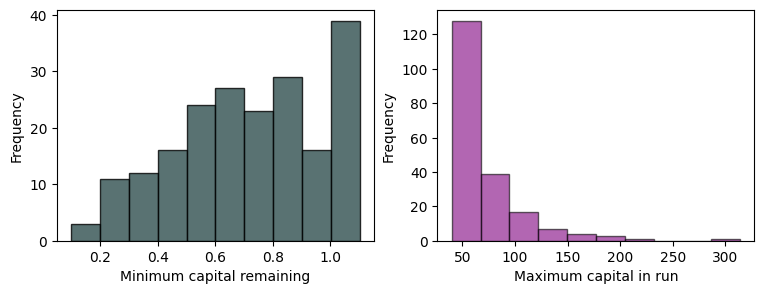

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].hist(np.array(mins), color='darkslategrey', edgecolor='black', alpha=0.8)
ax[0].set_xlabel('Minimum capital remaining')
ax[0].set_ylabel('Frequency')
ax[1].hist(np.array(max_caps), color='purple', edgecolor='black', alpha=0.6)
ax[1].set_xlabel('Maximum capital in run')
ax[1].set_ylabel('Frequency')

In [182]:
print('The lowest low is {}'.format(round(min(mins), 4)))

The lowest low is 0.0654


In [47]:
final_caps = []
mins = []
for coeff_max_thr in np.arange(1.1, 2.1, 0.02):
    np.random.shuffle(np_odd_stats)

    capital = 1
    fs, caps, ps, bet_sizes, maxs, avgs = [], [], [], [], [], []
    for i in np_odd_stats:
        coeff_max = min(i[:2])
        coeff_avg = min(i[2:])
        p = 1 / coeff_avg
        q = 1 - p
        f = p - q / (coeff_max - 1)
        fs.append(f)
        ps.append(p)
        bet_sizes.append(f * capital)
        maxs.append(coeff_max)
        avgs.append(coeff_avg)
        if (1 / coeff_avg - 1 / coeff_max > 0.05) and (coeff_max < coeff_max_thr):
            if i[0] < i[1]:
                capital += 0.5 * f * capital * (coeff_max - 1)
                caps.append(capital)
            else:
                capital -= 0.5 * f * capital
                caps.append(capital)
    final_caps.append(capital)
    mins.append(min(caps))
final_caps = np.array(final_caps)

(1.1, 2.0)

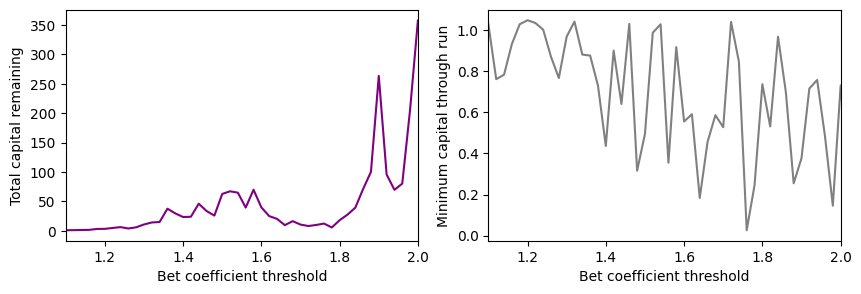

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(np.arange(1.1, 2.1, 0.02), final_caps, color='purple')
ax[0].set_xlabel('Bet coefficient threshold')
ax[0].set_ylabel('Total capital remaining')
ax[0].set_xlim([1.1, 2.0])
ax[1].plot(np.arange(1.1, 2.1, 0.02), mins, color='gray')
ax[1].set_xlabel('Bet coefficient threshold')
ax[1].set_ylabel('Minimum capital through run')
ax[1].set_xlim([1.1, 2.0])

Increasing the betting coefficient threshold (the highest coefficient to enter a bet) is equivalent to taking up more risk. We see that the potential winnings increase but so does the volatitly: there are much larger drawdowns at higher levels of risk.